**************************** PROCESSING SAMPLE DATA **********************************
To read in your own data, use sprit.run(input_data='/path/to/your/seismic/data.mseed')
      Any file format supported by osbpy.read() can be input to sprit_run()           
      Raw data (.trc) files from select Tromino Portable are also supported           
           See SpRIT Wiki or API documentation for more information:                  
              Wiki: https://github.com/RJbalikian/SPRIT-HVSR/wiki                     
          API Documentation: https://sprit.readthedocs.io/en/latest/#                 
**************************************************************************************

ph True


———————————————————————————————————————————————————————————————————————————————————————————————————
=                    SampleHVSRSite1_AM.RAC84.00.2023.046_2023-02-15_1704-1734                    =
—————————————————————————————————————————————————————————————————————————————————————————————

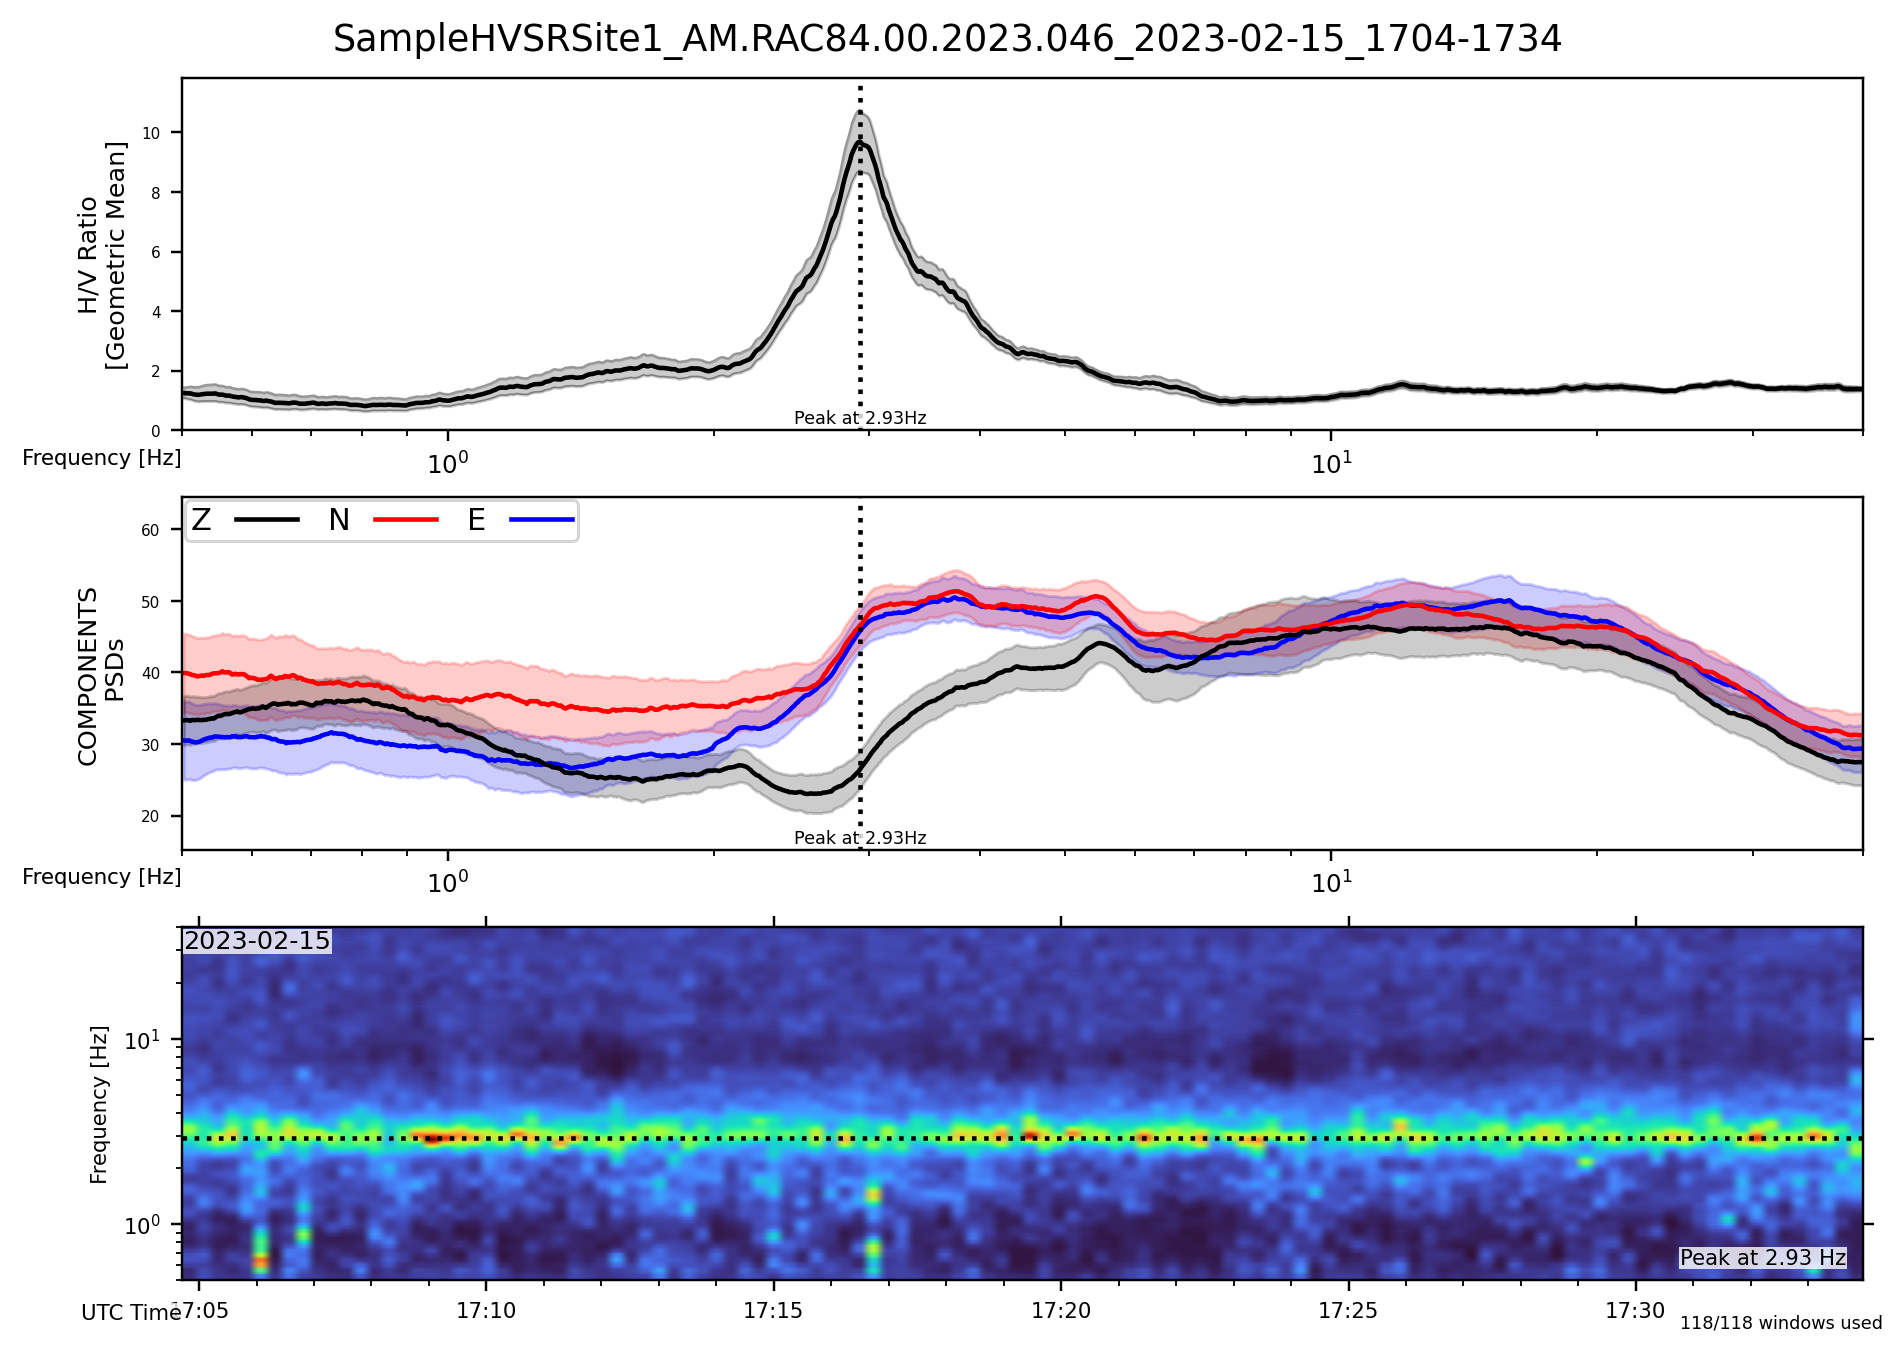

In [2]:
import sprit
hvData = sprit.run(suppress_report_outputs=True, show_plot_report=False)

In [253]:
for i, row in hvData.Table_Report.iterrows():
    hvData.Table_Report.loc[i, 'Acq_Date'] = str(row['Acq_Date'])
json.dumps(hvData.Table_Report.to_dict())

'{"Site Name": {"0": "SampleHVSRSite1_AM.RAC84.00.2023.046_2023-02-15_1704-1734"}, "Acq_Date": {"0": "2023-02-15"}, "Longitude": {"0": -88.229}, "Latitude": {"0": 40.101}, "Elevation": {"0": 225}, "Peak": {"0": 2.929}, "Peak_StDev": {"0": 0.121}, "PeakPasses": {"0": true}, "WinLen": {"0": true}, "SigCycles": {"0": true}, "LowCurveStD": {"0": true}, "ProminenceLow": {"0": true}, "ProminenceHi": {"0": true}, "AmpClarity": {"0": true}, "FreqStability": {"0": true}, "LowStDev_Freq": {"0": true}, "LowStDev_Amp": {"0": true}}'

In [ ]:
import datetime
import obspy
from pyproj import CRS
import obspy
import json
import numpy as np
import numbers
import pandas as pd

def to_json(self, json_filepath=None, export_json=True, return_json=False, **kwargs):
    """Not yet supported, will export HVSRData object to json"""

    # Not currently using this, but keeping for now
    class_keys_to_convert = (datetime.date, obspy.UTCDateTime, 
                            datetime.time, CRS, obspy.Inventory)

    stringOK = ['acq_date', 'starttime', 'endtime', 'input_crs', 'output_crs', 'inv',
                'input_stream', 'stream', 'stream_edited', 'current_times_used']

    channel_dicts = ['x_freqs', 'x_period', 'psd_raw', 'psds', 'psd_values_tavg', 
                    'ppsd_std', 'ppsd_std_vals_m', 'ppsd_std_vals_p'] 

    az_dicts = ['ind_hvsr_curves', 'ind_hvsr_stdDev', 'ind_hvsr_peak_indices', # need to fix these keys for consistency
                'hvsr_peak_indices', 'hvsr_peak_freqs', 'hvsr_log_std', # 'hvsr_curve', # need to fix this
                'hvsrp', 'hvsrm', 'hvsrp2', 'hvsrm2', #"BestPeak",
                ]

    #odd_dicts = ['PeakReport'] # This is just a repeat of "BestPeak"["Report"]
    dfs = ['hvsr_windows_df']

    plots = ['Input_Plot', "Plot_Report", "Outlier_Plot"]

    sKeys = True
    if 'sort_keys' in kwargs:
        sKeys = kwargs['sort_keys']
        del kwargs['sort_keys']

    indent = 4
    if 'indent' in kwargs:
        indent = kwargs['indent']
        del kwargs['indent']

    dict_for_json = {}
    dict_str_list = []
    for k, v in self.__dict__.items():
        if k=='_batch':
            continue
        
        # Get the Table Report formatted for json export
        if k == 'Table_Report':
            for i, row in v.iterrows():
                v.loc[i, 'Acq_Date'] = str(row['Acq_Date'])
            v = v.to_dict()

        try:
            json.dumps({k:v})
            dict_for_json[k] = v
        except Exception as e:
            dict_for_json[k] = str(v)

            if k in stringOK:
                dict_for_json[k] = str(v)
                #print(f'{k} was stringified')
                continue

            # Special processing for BestPeak dict
            if k == 'BestPeak':
                bpStr = indSpcs+f'"{k}": '+'{\n'+indSpcs+indSpcs
                del dict_for_json[k]
                for azName, azDict in v.items():
                    bpStr += f'"{azName}": ' + '{\n'+indSpcs+indSpcs+indSpcs
                    for azDictKey, azDictData in azDict.items():
                        if azDictKey == 'Report':
                            bpStr += f'"{azDictKey}": ' + '{\n'+indSpcs+indSpcs+indSpcs+indSpcs
                            for repKey, repVal in azDictData.items():
                                if repKey not in ['Table_Report', 'Print_Report']:
                                    if isinstance(repVal, bool):
                                        repVal = str(repVal).lower()
                                    bpStr += f'"{repKey}": "{repVal}", \n'+indSpcs+indSpcs+indSpcs+indSpcs
                        elif azDictKey == 'PassList':
                            bpStr += f'"{azDictKey}": '+ '{\n'+indSpcs+indSpcs+indSpcs+indSpcs+indSpcs
                            for plKey, plVal in azDictData.items():
                                plVal = str(plVal).lower()
                                bpStr += f'"{plKey}": {plVal}, \n'+indSpcs+indSpcs+indSpcs+indSpcs+indSpcs
                            bpStr = bpStr[:-1*(len(indSpcs)*5+3)] + '\n'+indSpcs+indSpcs+indSpcs+indSpcs+'},\n'
                            bpStr += indSpcs+indSpcs+indSpcs+indSpcs
                        else:
                            bpStr += f'"{azDictKey}": "{azDictData}", \n'+indSpcs+indSpcs+indSpcs
                    bpStr = bpStr[:-1*(3*len(indSpcs)+3)] + '\n'+indSpcs+indSpcs+indSpcs+'}'
                    bpStr += '\n'+indSpcs+indSpcs
                bpStr = bpStr + '}\n'+indSpcs+'}'+indSpcs
                dict_str_list.append(bpStr)

            
            # Special processing of hvsr_curve array
            if k == 'hvsr_curve':
                del dict_for_json[k]
                hvStr = indSpcs+'"hvsr_curve": '+str(np.round(v,5).tolist()).replace('\n', ' ')+',\n'
                dict_str_list.append(hvStr)

            # Special processing of processing_parameters dict
            if k == 'processing_parameters':
                del dict_for_json[k]
                ppStr = indSpcs+f'"{k}": '+'{\n'+indSpcs+indSpcs
                for funKey, funParam in v.items():
                    ppStr += f'"{funKey}": \n'+indSpcs+indSpcs+indSpcs+'{'
                    for prmName, prmVal in funParam.items():
                        if prmName == 'processing_paramters':
                            continue
                        
                        try:
                            if isinstance(prmVal, bool):
                                prmVal = str(prmVal).lower()
                            if prmVal is None:
                                prmVal = 'null'
                            
                            if isinstance(prmVal, numbers.Number):
                                ppStr += f'"{prmName}": {prmVal}, '
                            elif isinstance(prmVal, (list, tuple)):
                                newStr = f'"{prmName}": ['
                                for item in prmVal:
                                    if isinstance(item, numbers.Number):
                                        newStr += item +', '
                                    else:
                                        newStr += f'"{item}", '
                                ppStr += newStr[:-2]+'], '
                            else:
                                ppStr += f'"{prmName}": "{prmVal}", '
                        except:
                            ppStr += f'"{prmName}": "{prmVal}", '

                    strParam = funParam#.replace("'", '"')
                    ppStr = ppStr[:-2]+ '},\n'+indSpcs+indSpcs
                minInd = -1*(len(indSpcs)*2+3)
                dict_str_list.append(ppStr[:minInd]+'}\n'+indSpcs+'},\n')

            # Get string to add to end of json.dumps output later for dicts with az and channels
            indSpcs = ''.join([' ']*indent)
            if k in channel_dicts or k in az_dicts:
                del dict_for_json[k]
                dictString = f'{indSpcs}"{k}": '+'{\n'+indSpcs+indSpcs
                for chaz, chazVals in v.items():
                    if k == 'psds':
                        dictString += f'"{chaz}": ' + '{\n'+ indSpcs+indSpcs+indSpcs
                        for psdKey, psdVal in v[chaz].items():
                            #dictString += '{'+'{\n'+indSpcs+indSpcs+indSpcs
                            if isinstance(psdVal, np.ndarray):
                                dictString += json.dumps({psdKey: np.round(psdVal, 5).tolist()}).replace('{', '').replace("}", '') + ',\n'+indSpcs+indSpcs+indSpcs
                            else:
                                if isinstance(psdVal, (list, tuple)):
                                    newList = []
                                    for item in psdVal:
                                        newList.append(str(item))
                                    psdVal = newList
                                outerDict = {psdKey:psdVal}
                                dictString += json.dumps(outerDict).replace('{', '').replace("}", '') + ',\n'+indSpcs+indSpcs+indSpcs

                        dictString = dictString[:-14] +"\n" +indSpcs+indSpcs+"},\n"+indSpcs+indSpcs
                    else:
                        outDict = {chaz:chazVals}
                        if isinstance(chazVals, np.ndarray):
                            outDict = {chaz: np.round(chazVals, 3).tolist()}
                        if "Indices" in chaz:
                            listList = []
                            for arr in chazVals:
                                listList.append(arr.tolist())
                            outDict = {chaz: listList}

                        dictString += json.dumps(outDict).replace('{', '').replace("}", '') + ',\n'+indSpcs+indSpcs
                dict_str_list.append(dictString[:dictString.rfind(',')] + f'\n{indSpcs}'+'},\n')
    
    dict_str_list[-1] = dict_str_list[-1][:-2]+'\n'

    if export_json and json_filepath is not None:
        with open(json_filepath, 'w') as f:
            # dump the JSON string to the file
            json.dump(dict_for_json, 
                        fp=f,
                        sort_keys=sKeys, 
                        indent=indent,
                        **kwargs)

        with open(json_filepath, 'r') as f:
            readLines = f.readlines()
        readLines = readLines[:-1]
        readLines[-1] = readLines[-1].replace('\n',',\n')
        readLines.extend(dict_str_list)
        readLines.append('}')

        with open(json_filepath, encoding='UTF-8', mode='w') as f:
            f.writelines(readLines)

    if return_json or json_filepath is None:
        jsonString = json.dumps(dict_for_json,
                            sort_keys=sKeys, indent=indent, **kwargs)
        
        jsonStringOUT = jsonString
        if len(dict_str_list) > 1: 
            jsonStringOUT = jsonStringOUT[:-2]+',\n'

        for ds in dict_str_list:
            jsonStringOUT = jsonStringOUT + ds
        return jsonStringOUT + '}'

to_json(hvData, json_filepath=r"C:\Users\riley\LocalData\repos\SPRIT-HVSR\out.json")
jsonString = to_json(hvData)
newDict = json.loads(jsonString)

WORKING {"Site Name": {"0": "SampleHVSRSite1_AM.RAC84.00.2023.046_2023-02-15_1704-1734"}, "Acq_Date": {"0": "2023-02-15"}, "Longitude": {"0": -88.229}, "Latitude": {"0": 40.101}, "Elevation": {"0": 225}, "Peak": {"0": 2.929}, "Peak_StDev": {"0": 0.121}, "PeakPasses": {"0": true}, "WinLen": {"0": true}, "SigCycles": {"0": true}, "LowCurveStD": {"0": true}, "ProminenceLow": {"0": true}, "ProminenceHi": {"0": true}, "AmpClarity": {"0": true}, "FreqStability": {"0": true}, "LowStDev_Freq": {"0": true}, "LowStDev_Amp": {"0": true}}
WORKING {"Site Name": {"0": "SampleHVSRSite1_AM.RAC84.00.2023.046_2023-02-15_1704-1734"}, "Acq_Date": {"0": "2023-02-15"}, "Longitude": {"0": -88.229}, "Latitude": {"0": 40.101}, "Elevation": {"0": 225}, "Peak": {"0": 2.929}, "Peak_StDev": {"0": 0.121}, "PeakPasses": {"0": true}, "WinLen": {"0": true}, "SigCycles": {"0": true}, "LowCurveStD": {"0": true}, "ProminenceLow": {"0": true}, "ProminenceHi": {"0": true}, "AmpClarity": {"0": true}, "FreqStability": {"0": 